In [49]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
from IPython.core.pylabtools import figsize
figsize(15, 5)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)

libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)

    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldingsCVX
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [50]:
dl = DataLoader(prices_dir='../price_data_utils/prices', info_dir='../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../price_data_utils/cached')
dl.load_data()
data = dl.data

Prediction Date: 2019-08-09


In [51]:
hp = HistoricalPrices(prices_dir='../price_data_utils/prices', 
                      cached_dir='../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [52]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [53]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')

In [54]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [55]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [56]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [57]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


In [58]:
rets = returns.loc['2014-01-01':'2015-12-31']
print(rets.shape)
rets.head()

(504, 741)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.011680,-0.002643,-0.014444,-0.010597,-0.008684,-0.002346,-0.013737,-0.003920,-0.011476,-0.007286,...,-0.020169,-0.007800,0.002308,-0.016520,-0.009183,-0.001085,-0.007096,-0.003666,-0.011597,-0.014623
2014-01-03,-0.000909,0.058839,0.008963,-0.017236,0.002212,0.007381,0.001563,0.005902,-0.002126,0.001198,...,-0.014221,-0.011893,0.013487,0.006746,-0.000185,-0.040994,0.006837,0.000115,0.004380,-0.001012
2014-01-06,0.001365,-0.014768,-0.001561,-0.006748,0.006161,-0.008429,-0.014900,-0.006757,-0.012781,-0.010473,...,-0.006454,0.003570,0.004544,-0.006154,-0.012792,0.006419,-0.009259,-0.004368,-0.000318,0.004389
2014-01-07,0.013630,-0.017022,0.008416,0.007602,-0.011456,0.010789,0.014117,0.009309,0.020415,0.009828,...,-0.005350,0.020226,0.006462,0.004954,0.012394,0.033168,0.000623,0.001963,0.009202,0.005714
2014-01-08,-0.000896,0.060222,0.000596,0.017926,-0.003925,0.022319,-0.003409,-0.011884,-0.002765,0.001497,...,-0.011909,0.000996,-0.006421,0.001369,0.005008,0.001235,-0.003425,0.001383,-0.000315,-0.009024


In [59]:
risk_model = RiskModelPCA(rets, 20)

<BarContainer object of 20 artists>

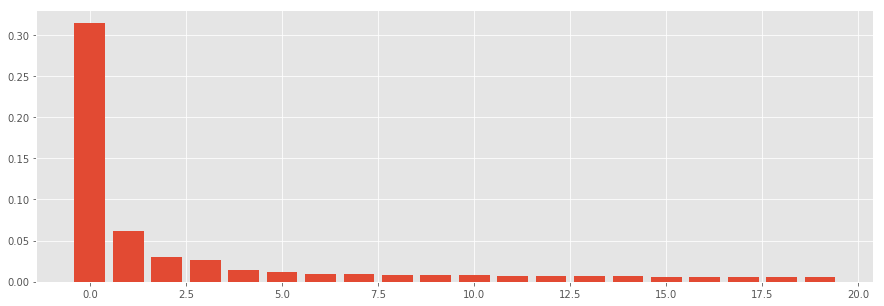

In [60]:
plt.bar(np.arange(risk_model.n_components), risk_model.pca.explained_variance_ratio_)

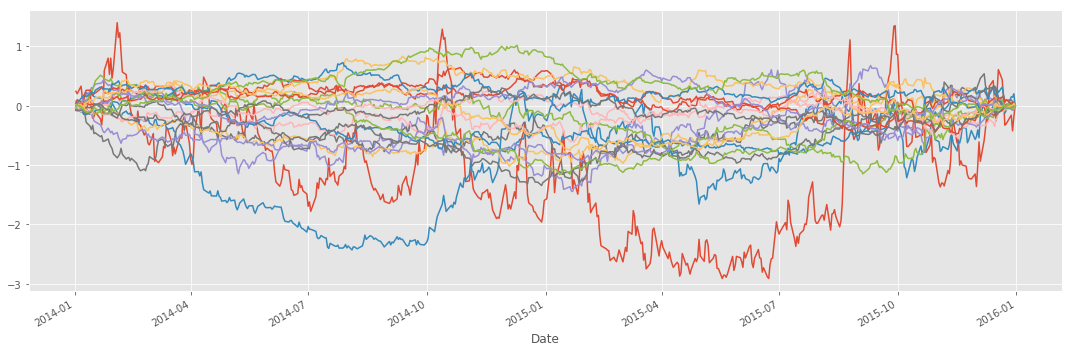

In [61]:
# looking at factor returns
risk_model.factor_returns.cumsum().plot(legend=False)
plt.tight_layout()

In [62]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()

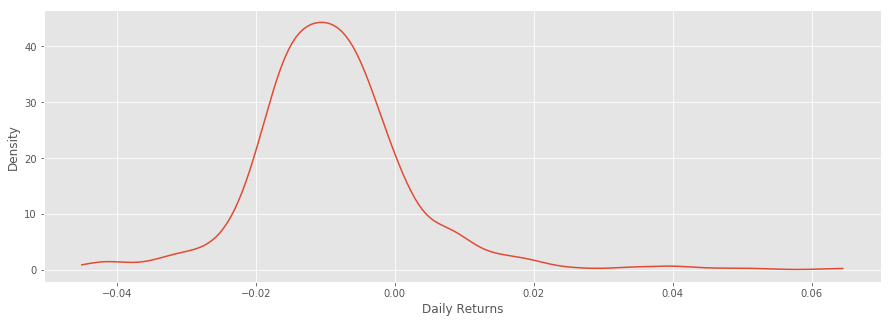

In [63]:
density_plot(risk_model.unwinz_returns.iloc[0])

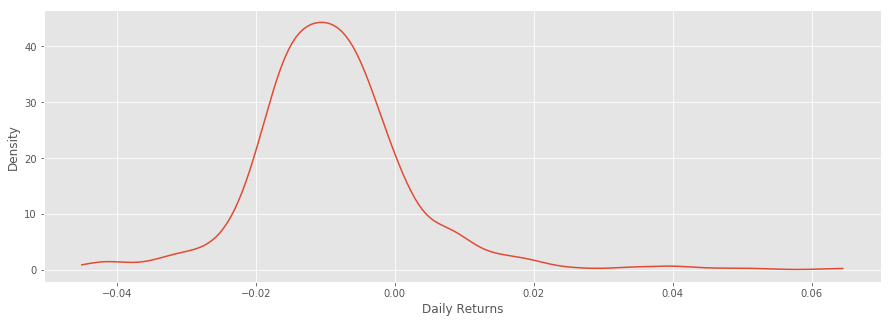

In [64]:
density_plot(risk_model.returns.iloc[0])

In [65]:
holdings = [1 / len(rets.columns)] * len(rets.columns)
print(holdings[:5])
np.sqrt(risk_model.predict_portfolio_risk_opt(holdings, 1))

[0.001349527665317139, 0.001349527665317139, 0.001349527665317139, 0.001349527665317139, 0.001349527665317139]
this is h2.shape:  (741,)
this is ivv.shape:  (741, 1)


0.13830879851271666

In [66]:
aum = 50000000
holdings = np.asarray(holdings) * aum
np.sqrt(risk_model.predict_portfolio_risk_opt(holdings, aum))

this is h2.shape:  (741,)
this is ivv.shape:  (741, 1)


0.13830879851271666

In [67]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [68]:
momentum = create_momentum_factor(p, sector_data)
momentum.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [69]:
momentum.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,-0.378412,-0.327022,-0.967052,-0.887632,1.401525,-1.471601,-1.139907,-0.682075,-0.854930,-0.803541,...,1.093189,0.042046,0.102778,0.397099,-0.317679,-1.294075,0.607327,1.051144,-0.467175,0.780182
2015-12-30,-0.406442,-0.551266,-0.990411,-0.840915,1.350136,-1.476273,-1.107205,-0.742808,-0.925006,-0.798869,...,1.107205,0.093435,0.140152,0.406442,-0.308335,-1.177281,0.509221,1.009098,-0.411114,0.780182
2015-12-31,-0.345709,-0.672732,-0.976396,-0.920335,1.373494,-1.476273,-1.130563,-0.682075,-0.910991,-0.794197,...,1.055815,0.158839,0.196213,0.387755,-0.266290,-1.195968,0.644701,1.032457,-0.397099,0.808213
2016-01-04,-0.401770,-0.747480,-0.981067,-0.719449,1.289403,-1.452914,-1.093189,-0.434473,-0.915663,-0.784854,...,1.060487,0.032702,0.200885,0.397099,-0.341038,-1.065159,0.649373,1.102533,-0.425129,0.794197
2016-01-05,-0.369068,-0.854930,-0.981067,-0.574625,1.317433,-1.448242,-1.102533,-0.317679,-0.910991,-0.798869,...,1.041800,-0.014015,0.102778,0.298992,-0.308335,-1.139907,0.565282,1.181953,-0.378412,0.850258


In [70]:
risk_model.returns.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-24,-0.000730,0.024507,-0.004124,-0.000511,-0.001761,-0.001083,-0.003024,-0.018930,-0.015060,0.007036,...,0.000000,0.000149,0.003299,0.001808,-0.000373,-0.012554,-0.014908,-0.009635,-0.006595,0.000584
2015-12-28,-0.002557,-0.012881,0.003727,-0.000621,-0.003015,-0.011522,-0.014407,-0.000919,-0.030887,-0.027743,...,-0.001250,0.000448,0.009360,-0.004769,-0.004478,-0.029839,0.017427,0.000246,0.014967,-0.003502
2015-12-29,0.016844,0.004914,0.005226,0.011442,0.000048,0.005143,0.016838,0.011649,0.017356,0.028535,...,0.015645,0.016194,0.008271,0.006345,0.008997,0.030757,-0.002930,0.012682,0.003358,0.008787
2015-12-30,-0.008642,-0.030186,-0.013817,-0.001554,-0.000279,-0.009209,-0.002665,-0.010000,-0.038461,-0.008015,...,-0.004313,-0.003892,-0.001989,-0.007592,-0.007183,-0.001038,-0.011076,-0.015684,-0.004511,-0.002903
2015-12-31,-0.013440,-0.003652,-0.008323,-0.011493,-0.003965,-0.003718,-0.009733,0.001836,0.032258,-0.008908,...,-0.016089,-0.007815,-0.002491,-0.006613,-0.009355,-0.015844,0.007543,-0.004323,-0.004473,-0.006115


In [71]:
factor_data = {}
start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-12-31')

factor_data['momentum'] = momentum.loc[start:end,:].stack()
factor_data['momentum'].head()
factor_prices = p.loc[start:end, :]
print(factor_prices.shape)
print(factor_data['momentum'].shape)
factor_returns = al.utils.get_clean_factor_and_forward_returns(factor=factor_data['momentum'], prices=factor_prices, periods=[1])

(504, 741)
(373464,)
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


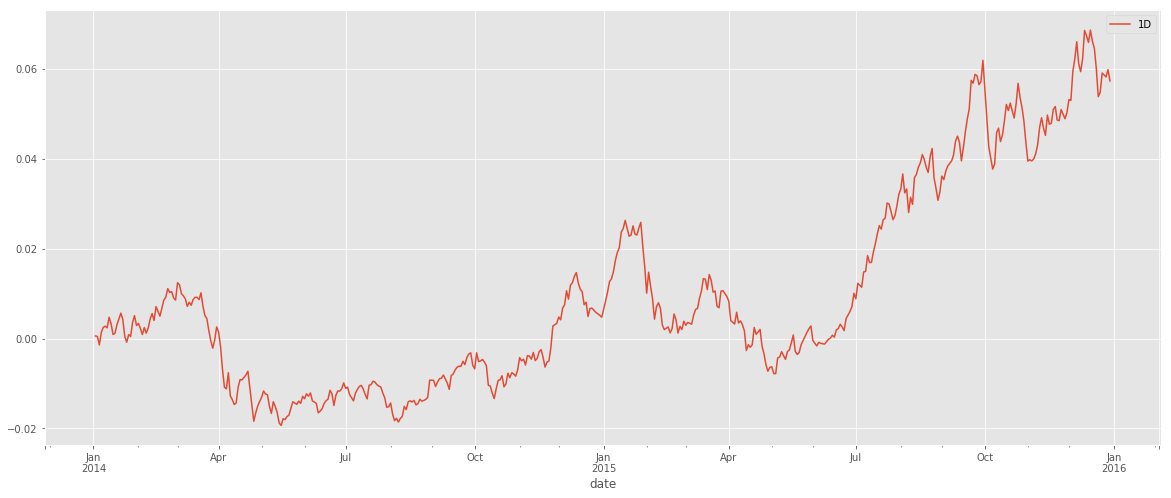

In [72]:
figsize(20,8)
factor_returns_data = al.performance.factor_returns(factor_returns)
factor_returns_data.cumsum().plot()

In [73]:
sharpe = factor_returns_data.mean() * np.sqrt(252) / factor_returns_data.std()
sharpe

1D    0.835379
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129a6f9b0>,
      dtype=object)

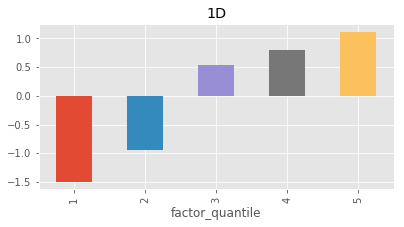

In [74]:

qr_factor_returns = al.performance.mean_return_by_quantile(factor_returns)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

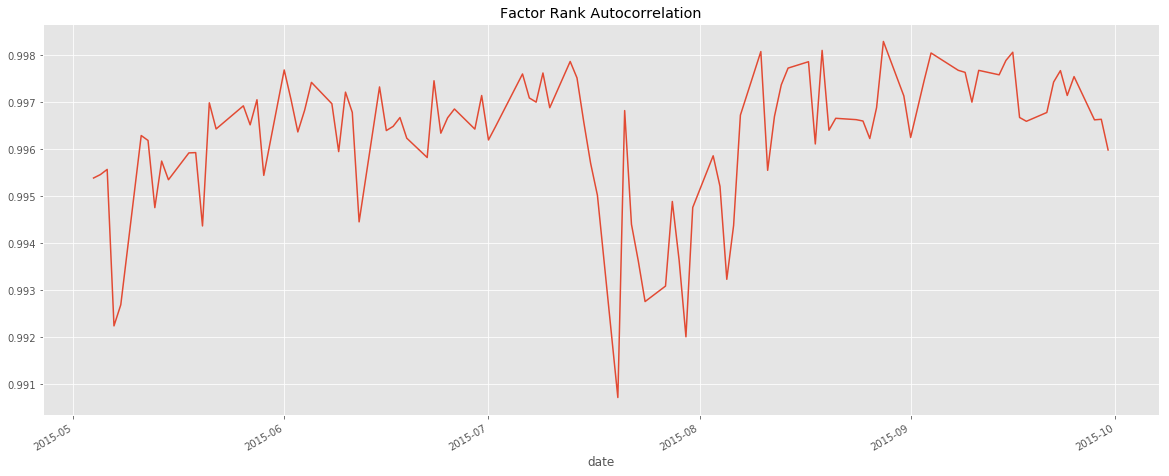

In [27]:
ls_FRA = al.performance.factor_rank_autocorrelation(factor_returns)

ls_FRA.plot(title="Factor Rank Autocorrelation")

In [28]:
rets_index = rets.index[-1]
alpha_vector = momentum.loc[rets_index, :]
print(type(alpha_vector))
len(alpha_vector)

<class 'pandas.core.series.Series'>


741

In [29]:
previous = np.asarray(holdings) / 50000000
len(previous)
previous[:5]

array([0.00134953, 0.00134953, 0.00134953, 0.00134953, 0.00134953])

In [30]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, aum=50e6, lambda_reg=0.00,
                 factor_min=-10.0, weights_max=0.55, weights_min=-0.55, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min
        self.factor_max = factor_max
        self.weights_min = weights_min
        self.weights_max = weights_max
        self.risk_aversion = risk_aversion
        self.aum = aum
        self.lambda_reg = lambda_reg

    def _get_obj(self, h1):
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector
        #h0 = self.previous.flatten()
        #lv = np.ones((len(av), 1)) * 0.1/2000000
        #obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2) + (h1-h0)**2 @ lv)
        obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2))

        return obj_func

    def _get_constraints(self, h1, risk):
        c = []
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(h1) == 0)
        c.append(sum(cvx.abs(h1)) <= 1.0)
        c.append(h1 >= self.weights_min)
        c.append(h1 <= self.weights_max)
        return c

    def get_risk(self, h1):
        av_index = self.alpha_vector.index
        ivm = self.risk_model.i_var_matrix.loc[av_index].values
        f = self.risk_model.factor_exposures.loc[av_index].values.T @ h1
        X = self.risk_model.factor_cov_matrix
        risk = cvx.quad_form(f, X) + cvx.quad_form(h1, ivm)
        return risk

    def find(self):
        h1 = cvx.Variable(len(self.alpha_vector))
        risk = self.get_risk(h1)
        obj_func = self._get_obj(h1)
        constraints = self._get_constraints(h1, risk)
        prob = cvx.Problem(obj_func, constraints)
        prob.solve(max_iters=100, verbose=True)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index)
        return df

In [31]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, previous, lambda_reg=5.0)
optimal_weights = oh.find()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +2.001e-17  -2.487e+03  +1e+06  8e-01  7e-01  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  -7.894e+01  -3.745e+02  +1e+05  6e-02  9e-02  2e-01  1e-01  0.9890  1e-01   2  2  2 |  0  0
 2  -1.468e+01  -4.998e+01  +2e+04  7e-03  1e-02  3e-02  2e-02  0.8922  2e-02   3  2  3 |  0  0
 3  -3.075e+00  -8.503e+00  +3e+03  1e-03  2e-03  4e-03  3e-03  0.9519  1e-01   5  4  4 |  0  0
 4  -1.459e+00  -2.214e+00  +4e+02  2e-04  2e-04  4e-04  4e-04  0.8536  1e-02   8  7  8 |  0  0
 5  -1.227e+00  -1.306e+00  +4e+01  2e-05  2e-05  7e-05  4e-05  0.9368  3e-02   1  1  1 |  0  0
 6  -1.176e+00  -1.182e+00  +3e+00  1e-06  1e-06  5e-06  3e-06  0.9352  1e-02   2  2  2 |  0  0
 7  -1.172e+00  -1.173e+00  +5e-01  2e-07  2e-07  7e-07  5e-07  0.8954  8e-02   2  2  2 |  0  0
 8  -1.171e+00  -1.172e+00  +2e-01  7e-08  8e-

/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


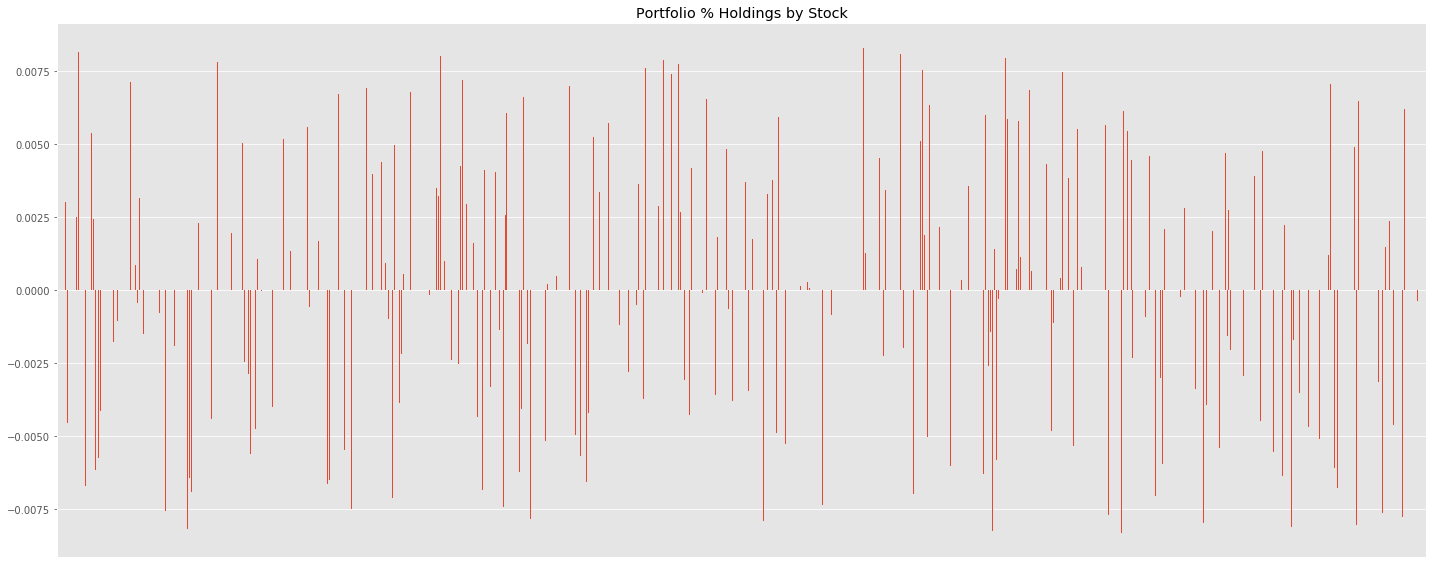

In [32]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

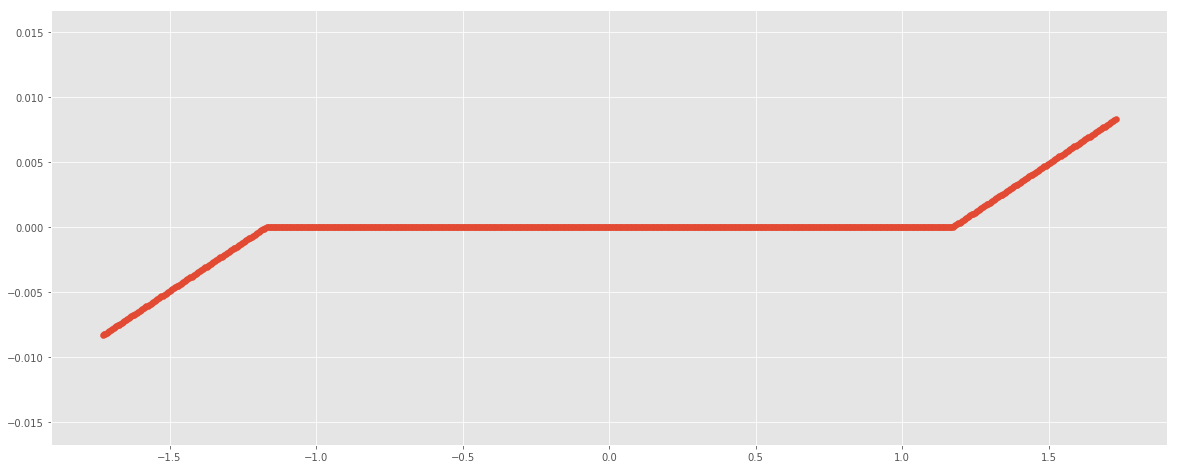

In [33]:
plt.scatter(alpha_vector, optimal_weights)

In [34]:
print(len(alpha_vector))
print(len(optimal_weights))
print(alpha_vector.head())
print(optimal_weights.head())

741
741
ticker
CSCO   -0.345709
UAL    -0.672732
TROW   -0.976396
ISRG   -0.920335
NVR     1.373494
Name: 2015-12-31 00:00:00, dtype: float64
                   0
ticker              
CSCO   -9.181216e-15
UAL    -2.435021e-14
TROW   -7.766664e-14
ISRG   -5.837649e-14
NVR     3.016487e-03


In [35]:
def get_transfer_coefficient(a, b):
    tc, p = spearmanr(a, b)
    return tc

In [36]:
av = alpha_vector.values
r = optimal_weights.values.flatten()
print(av.shape)
print(r.shape)

(741,)
(741,)


In [37]:
get_transfer_coefficient(av, r)

1.0

In [38]:
class OptimalHoldingsCVX:

    def __init__(self, risk_model, alpha_vector, previous, risk_cap=0.05, factor_max=10.0, gmv=5e3, lambda_reg=0.00,
                 factor_min=-10.0, weights_max=0.02, weights_min=-0.02, risk_aversion=1.0e-6):

        self.risk_model = risk_model
        self.alpha_vector = alpha_vector
        self.previous = previous
        self.risk_cap = risk_cap
        self.factor_min = factor_min
        self.factor_max = factor_max
        self.weights_min = weights_min * gmv
        self.weights_max = weights_max * gmv
        self.risk_aversion = risk_aversion
        self.gmv = gmv
        self.lambda_reg = lambda_reg

    def _get_obj(self, h1):
        ra = self.risk_aversion
        Q = self.risk_model.Q # Q is k x N
        ivv = self.risk_model.i_var_vector
        av = -self.alpha_vector
        h0 = self.previous.flatten()
        lv = np.ones((len(av), 1)) * 0.1/10000000
        obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2) + (h1-h0)**2 @ lv)
        #obj_func = cvx.Minimize(np.array(av.T) * h1 + self.lambda_reg * cvx.norm(h1, 2))

        return obj_func

    def _get_constraints(self, h1, risk):
        c = []
        factor_exposures = self.risk_model.factor_exposures
        c.append(risk <= self.risk_cap**2)
        c.append(factor_exposures.T @ h1 <= self.factor_max)
        c.append(factor_exposures.T @ h1 >= self.factor_min)
        c.append(sum(h1) == 0)
        c.append(sum(cvx.abs(h1)) <= self.gmv)
        c.append(h1 >= self.weights_min)
        c.append(h1 <= self.weights_max)
        return c

    def get_risk(self, h1):
        av_index = self.alpha_vector.index
        ivm = self.risk_model.i_var_matrix.loc[av_index].values
        f = self.risk_model.factor_exposures.loc[av_index].values.T @ h1
        X = self.risk_model.factor_cov_matrix
        risk = cvx.quad_form(f, X) + cvx.quad_form(h1/self.gmv, ivm)
        return risk

    def find(self):
        h1 = cvx.Variable(len(self.alpha_vector))
        risk = self.get_risk(h1)
        obj_func = self._get_obj(h1)
        constraints = self._get_constraints(h1, risk)
        prob = cvx.Problem(obj_func, constraints)
        prob.solve(max_iters=100, verbose=True)
        optimal_weights = np.asarray(h1.value).flatten()
        df = pd.DataFrame(optimal_weights, index=self.alpha_vector.index, columns=['holdings'])
        return df

In [39]:
initial_holdings = np.zeros((len(alpha_vector), 1))  / len(alpha_vector)
print(initial_holdings.shape)
initial_holdings[:5]

(741, 1)


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [40]:
oh = OptimalHoldingsCVX(risk_model, alpha_vector, initial_holdings, lambda_reg=5.0)
optimal_weights = oh.find()


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.577e-16  -1.866e+05  +1e+06  9e-02  8e-01  1e+00  1e+00    ---    ---    2  1  - |  -  - 
 1  -1.880e+00  -3.007e+04  +2e+05  1e-02  2e-01  2e-01  2e-01  0.8425  6e-03   2  2  2 |  0  0
 2  -7.276e+00  -4.359e+03  +3e+04  2e-03  3e-02  4e-02  3e-02  0.9541  9e-02   2  2  2 |  0  0
 3  -2.605e+01  -2.664e+03  +2e+04  1e-03  2e-02  3e-02  1e-02  0.4534  8e-02   3  3  4 |  0  0
 4  -2.854e+01  -2.965e+03  +2e+04  1e-03  2e-02  3e-02  1e-02  0.1426  9e-01   3  4  4 |  0  0
 5  -3.205e+01  -3.180e+03  +2e+04  2e-03  2e-02  4e-02  1e-02  0.1000  8e-01   3  4  4 |  0  0
 6  -6.360e+01  -1.336e+03  +5e+03  7e-04  8e-03  2e-02  5e-03  0.8161  2e-01   3  4  4 |  0  0
 7  -1.321e+02  -1.089e+03  +3e+03  5e-04  6e-03  2e-02  3e-03  0.5709  3e-01   3  3  3 |  0  0
 8  -4.779e+02  -1.318e+03  +1e+03  5e-04  9e-

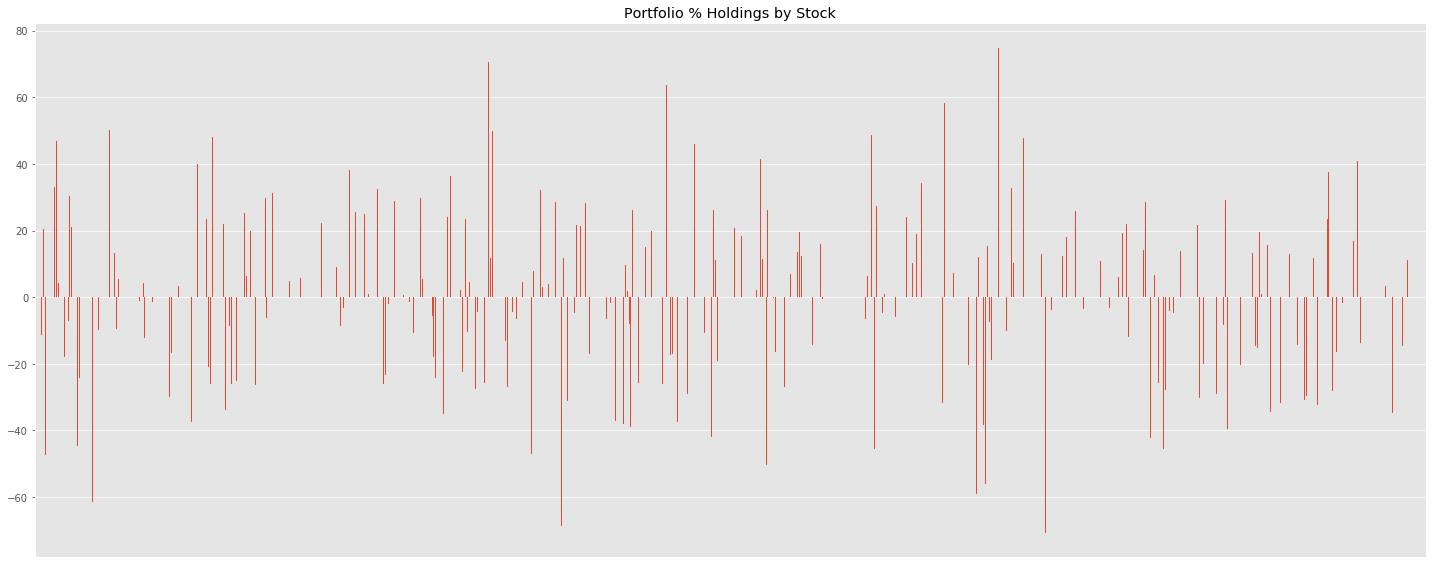

In [41]:
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

In [42]:
optimal_weights.head()

,holdings
ticker,
CSCO,-8.080527e-07
UAL,-9.134056e-07
TROW,-5.071902e-06
ISRG,-1.136673e+01
NVR,2.047374e+01


In [43]:
print('average long holdings: ', optimal_weights.loc[optimal_weights['holdings'] > 0].mean().values[0].round(4))
print('max long holding: ', optimal_weights.loc[optimal_weights['holdings'] > 0].max().values[0].round(4))
print('average short holdings: ', optimal_weights.loc[optimal_weights['holdings'] <= 0].mean().values[0].round(4))
print('max short holding: ', optimal_weights.loc[optimal_weights['holdings'] < 0].min().values[0].round(4))
print('gmv = ', optimal_weights.loc[optimal_weights['holdings'] > 0].sum() + optimal_weights.loc[optimal_weights['holdings'] < 0].abs().sum().values[0])

average long holdings:  6.7568
max long holding:  74.8945
average short holdings:  -6.7385
max short holding:  -70.7802
gmv =  holdings    4999.999022
dtype: float64


In [44]:
np.sqrt(risk_model.predict_portfolio_risk_opt(optimal_weights.values.flatten(), 5000))

this is h2.shape:  (741,)
this is ivv.shape:  (741, 1)


0.016695784202779708

In [45]:
def backtest(test_period, holdings, returns, alpha, gmv):
    port = {}
    for d in tqdm(test_period):
        str_d = d.strftime('%Y%m%d')
        end_date = d
        start_date = d - dt.timedelta(days=365)
        av = alpha.loc[end_date, :]
        rets = returns.loc[start_date:end_date, :]
        lambda_vector = np.ones((1, len(av))) * 0.1/10000000
        rm = RiskModelPCA(rets, 20)
        start = time.time()
        oh = OptimalHoldingsCVX(rm, av, holdings, lambda_reg=7.0, gmv=gmv)
        end = time.time()
        start = time.time()
        new_holdings = oh.find()
        end = time.time()
        data = np.matmul(rm.factor_exposures.values.T, new_holdings.values).flatten()
        risk_exposures = pd.Series(data=data.T, index=rm.factor_exposures.columns.values) 
        alpha_exposures = pd.Series(av * new_holdings['holdings'], index=av.index) 
        transaction_costs = np.dot(lambda_vector, (new_holdings - holdings)**2).flatten()
        print('TRANSACTION COSTS: ', transaction_costs)
        result = {
            'h.opt.previous': holdings,
            'h.opt': new_holdings,
            'risk.exposures': risk_exposures,
            'alpha.exposures': alpha_exposures,
            't.costs': transaction_costs,
            'factor.exposures': rm.factor_exposures,
            'alpha.vector': av,
            'rm': rm
        }
        print('RISK: ', np.sqrt(rm.predict_portfolio_risk_opt(new_holdings.values.flatten(), gmv)))
        port[str_d] = result
        holdings = np.asarray(new_holdings)
    return port

In [86]:
test_period = momentum.loc['2015-05-01':'2015-07-31'].index
print(test_period[:5])
initial_holdings = np.zeros((len(momentum.columns), 1))
port = backtest(test_period, initial_holdings, returns, momentum, 10000)






  0%|          | 0/64 [00:00<?, ?it/s]

DatetimeIndex(['2015-05-01', '2015-05-04', '2015-05-05', '2015-05-06',
               '2015-05-07'],
              dtype='datetime64[ns]', name='Date', freq=None)


KeyboardInterrupt: 

factor_0    0.002008
factor_1    0.006009
factor_2    0.003795
factor_3    0.015021
factor_4    0.002467
dtype: float64


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


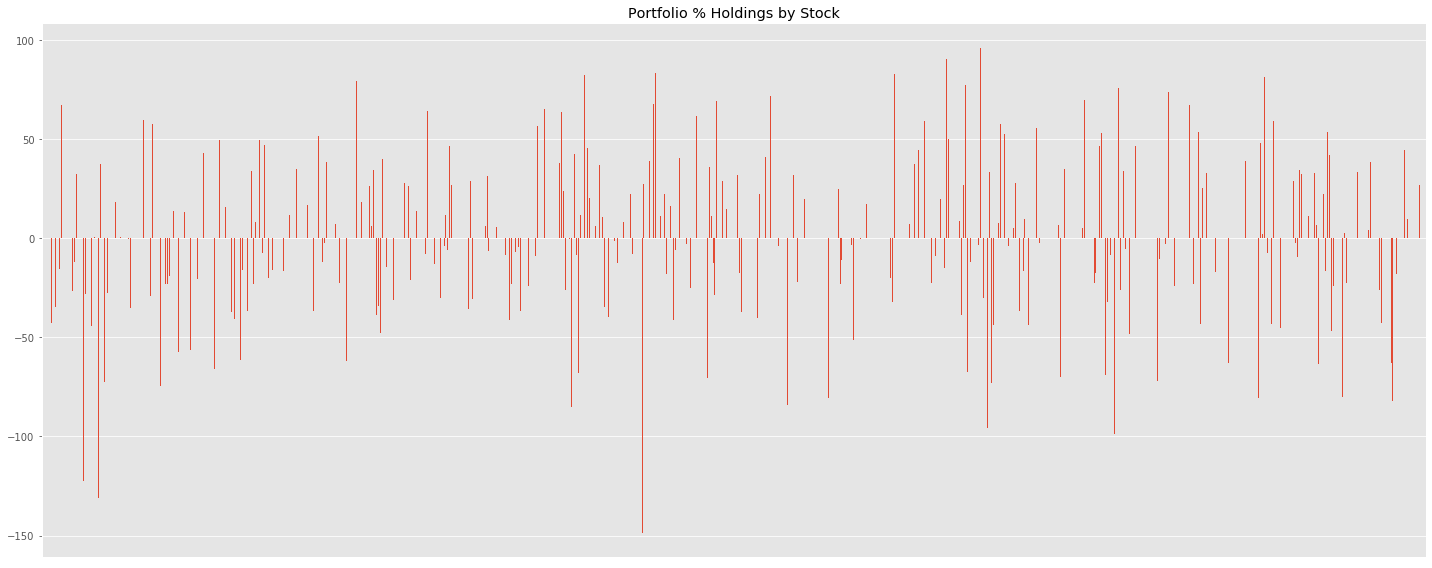

In [76]:
index_ = list(port.keys())[-1]
p = port[index_]
print(p['risk.exposures'].head())

optimal_weights = p['h.opt']
figsize(20, 8)
optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.tight_layout()

In [77]:
print('average long holdings: ', optimal_weights.loc[optimal_weights['holdings'] > 0].mean().values[0].round(4))
print('max long holding: ', optimal_weights.loc[optimal_weights['holdings'] > 0].max().values[0].round(4))
print('average short holdings: ', optimal_weights.loc[optimal_weights['holdings'] <= 0].mean().values[0].round(4))
print('max short holding: ', optimal_weights.loc[optimal_weights['holdings'] < 0].min().values[0].round(4))
print('gmv = ', optimal_weights.loc[optimal_weights['holdings'] > 0].sum() + optimal_weights.loc[optimal_weights['holdings'] < 0].abs().sum().values[0])

average long holdings:  13.1234
max long holding:  95.9873
average short holdings:  -13.8889
max short holding:  -148.7307
gmv =  holdings    10000.000002
dtype: float64


In [78]:
shifted_rets = rets.shift(-2)
print(rets.loc[:,['AAPL']].head())
print(shifted_rets.loc[:,['AAPL']].head())

ticker          AAPL
Date                
2014-01-02 -0.014064
2014-01-03 -0.021966
2014-01-06  0.005453
2014-01-07 -0.007152
2014-01-08  0.006333
ticker          AAPL
Date                
2014-01-02  0.005453
2014-01-03 -0.007152
2014-01-06  0.006333
2014-01-07 -0.012770
2014-01-08 -0.006673


In [79]:
def wins(x, a=-0.50, b=0.50):
    return np.where(x <= a,a, np.where(x >= b, b, x))

In [80]:
def estimate_factor_returns(exposures, returns):
    lr = LinearRegression()
    lr.fit(exposures, returns)
    return lr.coef_
    

In [81]:
def build_pnl_attribution(port, returns, alpha, date_index):
    df = pd.DataFrame(index=date_index)
    
    for date_ in date_index:
        date_str = date_.strftime('%Y%m%d')
        rets = returns.loc[date_, :].apply(wins)
        p = port[date_str]
        
        df.at[date_, 'daily.pnl'] = np.sum(p['h.opt']['holdings'] * rets)
        
        alpha_returns = estimate_factor_returns(p['alpha.vector'].values.reshape((len(p['alpha.vector']), 1)), wins(rets, -0.25, 0.25))
        df.at[date_, 'attribution.alpha.pnl'] = np.sum(alpha_returns * p['alpha.exposures'])
        
        factor_returns = estimate_factor_returns(p['factor.exposures'], wins(rets, -0.25, 0.25))
        df.at[date_, 'attribution.risk.pnl'] = np.sum(factor_returns * p['risk.exposures'])
        df.at[date_, 't.costs'] = p['t.costs']
        
        
    return df


In [82]:
df = build_pnl_attribution(port, shifted_rets, momentum, test_period)

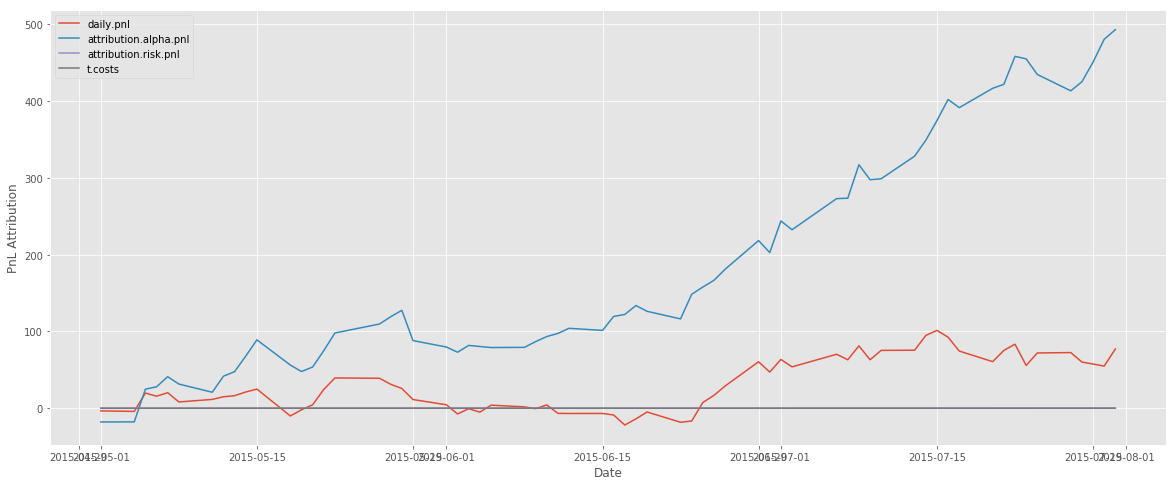

In [83]:
attr = build_pnl_attribution(port, shifted_rets, momentum, test_period)

for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [68]:
def build_portfolio_characteristics(my_dates, port): 
    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        h = p['h.opt']
        h0 = pd.DataFrame(p['h.opt.previous'], index=h.index)
        
        # TODO: Implement
        longs = np.sum(h[h>0]).values
        shorts = np.sum(h[h<0]).values

        df.at[dt,"long"] = longs
        df.at[dt,"short"] = shorts
        df.at[dt,"net"] = longs + shorts
        df.at[dt,"gmv"] = longs + np.abs(shorts)
        
        #df.at[dt,"traded"] = np.sum(np.abs(h - h0)).values
        
    return df

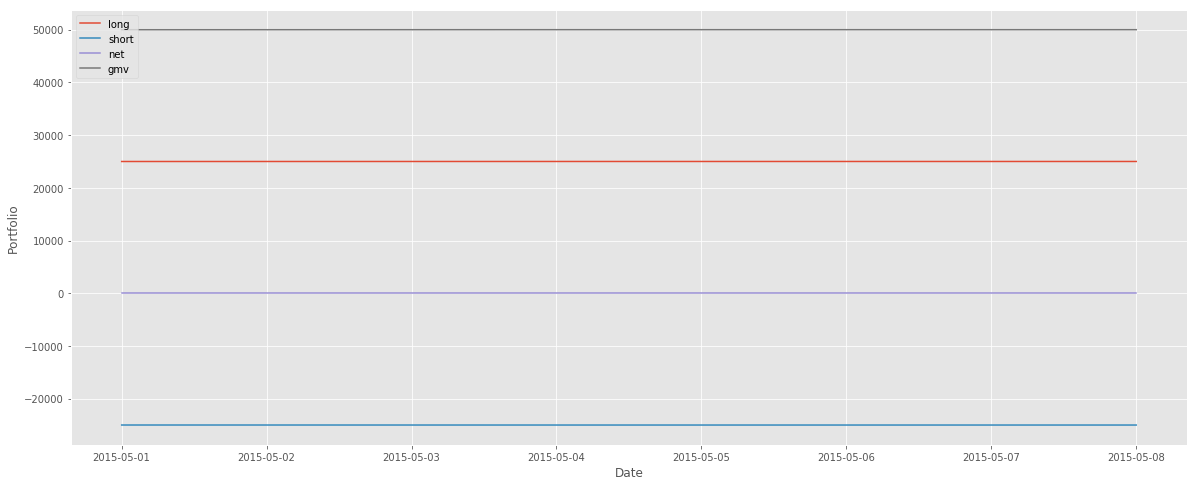

In [69]:
pchar = build_portfolio_characteristics(test_period, port)

for column in pchar.columns:
    plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()